In [279]:
# ✅ 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [280]:
import numpy as np
import pandas as pd
import os
import ast
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from textblob import TextBlob # Import TextBlob here
import nltk # Import nltk here

print("--- Starting comprehensive data setup and preprocessing ---")

# --- 0. Mount Google Drive for robustness ---
drive.mount('/content/drive')

# --- 1. Define Global Variables ---
DATA_PATH = "/content/MindscapeData/Mindscape Data"
ID_COLUMN_NAMES = {
    'text_diary_exports': 'entry_record_id',
    'prompts': 'prompt_record_id',
    'users': 'user_record_id',
    'events': 'event_record_id'
}
DATETIME_COLUMN_NAMES = ['day']
Q1_COLUMN_NAME = 'Q1'
STUDY_START_DATE = '2024-01-01'

print("✅ Global variables defined.")

# --- 2. Unzip Data Archive (ensuring data is available) ---
if not os.path.exists("/content/MindscapeData"): # Check for the parent directory of DATA_PATH
    print("Unzipping Mindscape Data.zip...")
    !unzip -o "/content/drive/MyDrive/Mindscape Data.zip" -d "/content/MindscapeData"
    print("✅ Data unzipped successfully!")
else:
    print("✅ Data directory already exists. No unzipping needed.")

# --- 3. Define Helper Functions ---
def clean_text_entry(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def parse_prompt_data(data_string):
    try:
        parsed_list = ast.literal_eval(data_string)
        prompt_type = None
        prompt_text = None

        if isinstance(parsed_list, list):
            if len(parsed_list) > 0:
                prompt_text = parsed_list[-1]

            if 'No manual key' in parsed_list or 'No auto key' in parsed_list:
                prompt_type = 'generic'
            elif len(parsed_list) > 2 and parsed_list[0] == 'Audio':
                if not ('No manual key' in parsed_list[1:-1] or 'No auto key' in parsed_list[1:-1]):
                    prompt_type = 'personalized'
                else:
                    prompt_type = 'generic'
            elif len(parsed_list) == 2 and parsed_list[0] == 'Audio':
                prompt_type = 'personalized'
            else:
                prompt_type = 'personalized'

            if prompt_text and ('your habits' in prompt_text or 'your feelings' in prompt_text or 'your day' in prompt_text or 'your thoughts' in prompt_text):
                prompt_type = 'personalized'

        return prompt_text, prompt_type
    except (ValueError, SyntaxError) as e:
        return None, None

def parse_q1_from_data(data_string):
    if not isinstance(data_string, str):
        return None
    try:
        data_dict = json.loads(data_string)
        if 'Q1' in data_dict:
            return data_dict['Q1']
        return None
    except (json.JSONDecodeError, TypeError):
        return None

def categorize_participant_group(q1_value):
    if q1_value is None:
        return 'Other'
    try:
        q1_int = int(q1_value)
        if q1_int in [1, 2]:
            return '1 or 2'
        elif q1_int in [3, 4]:
            return '3 or 4'
        else:
            return 'Other'
    except ValueError:
        return 'Other'

def count_words(text, word_list):
    if not isinstance(text, str):
        return 0
    words = text.split()
    count = 0
    for word in words:
        if word in word_list:
            count += 1
    return count

def get_sentiment_scores(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0, 0.0 # Default for empty or non-string entries
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

def calculate_ttr(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0
    words = text.split()
    if not words:
        return 0.0
    return len(set(words)) / len(words)

def count_unique_words(text, word_list):
    if not isinstance(text, str) or not text.strip():
        return 0
    text_words = set(text.lower().split())
    target_words_set = set(word_list)
    unique_count = 0
    for word in text_words:
        if word in target_words_set:
            unique_count += 1
    return unique_count

print("✅ Helper functions defined.")

# Download necessary NLTK data for TextBlob (if not already present)
try:
    nltk.data.find('corpora/wordnet')
except LookupError: # Changed to LookupError
    print("Downloading wordnet...")
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/averaged_perceptron_tagger')
except LookupError: # Changed to LookupError
    print("Downloading averaged_perceptron_tagger...")
    nltk.download('averaged_perceptron_tagger')

# --- 4. Load CSV files and Initial Data Preparation ---
events = pd.read_csv(f"{DATA_PATH}/apps.csv")
prompts = pd.read_csv(f"{DATA_PATH}/journal_prompts.csv")
users = pd.read_csv(f"{DATA_PATH}/ema_exports.csv")
text_diary_exports = pd.read_csv(f"{DATA_PATH}/text_diary_exports.csv")

print("✅ All CSVs loaded!")

def rename_id_column(df, df_name):
    if 'Unnamed: 0' in df.columns:
        new_name = ID_COLUMN_NAMES.get(df_name, 'unnamed_id')
        df = df.rename(columns={'Unnamed: 0': new_name})
    return df

events = rename_id_column(events, 'events')
prompts = rename_id_column(prompts, 'prompts')
users = rename_id_column(users, 'users')
text_diary_exports = rename_id_column(text_diary_exports, 'text_diary_exports')

def convert_to_datetime(df, df_name):
    for col in DATETIME_COLUMN_NAMES:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

events = convert_to_datetime(events, 'events')
prompts = convert_to_datetime(prompts, 'prompts')
users = convert_to_datetime(users, 'users')
text_diary_exports = convert_to_datetime(text_diary_exports, 'text_diary_exports')

print("✅ Initial DataFrame renaming and datetime conversion complete.")

# --- 5. Preprocessing of Prompts and Text Entries (Feature Engineering Stage 1) ---
text_diary_exports['cleaned_entry'] = text_diary_exports['data'].apply(clean_text_entry)

# Apply parse_prompt_data
prompts[['prompt_text_original', 'prompt_category_original']] = prompts['data'].apply(lambda x: pd.Series(parse_prompt_data(x)))

# Extract q1_extracted from users for participant categorization
users['q1_extracted'] = users['data'].apply(parse_q1_from_data)

print("✅ Text entries cleaned and prompt/Q1 extracted.")

# --- 6. Clean & Filter Data for Merging ---
text_diary_exports_cleaned = text_diary_exports.dropna(subset=['uid', 'day']).copy()
prompts_cleaned = prompts.dropna(subset=['uid', 'day']).copy()
users_cleaned = users.dropna(subset=['uid', 'day']).copy()

text_diary_exports_cleaned['uid'] = text_diary_exports_cleaned['uid'].astype(str)
prompts_cleaned['uid'] = prompts_cleaned['uid'].astype(str)
users_cleaned['uid'] = users_cleaned['uid'].astype(str)

text_diary_exports_cleaned = text_diary_exports_cleaned.drop_duplicates(subset=['uid', 'day'], keep='first')

# Filter out 'test' participants
text_diary_exports_cleaned = text_diary_exports_cleaned[~text_diary_exports_cleaned['uid'].str.startswith('test')].copy()
prompts_cleaned = prompts_cleaned[~prompts_cleaned['uid'].str.startswith('test')].copy()
users_cleaned = users_cleaned[~users_cleaned['uid'].str.startswith('test')].copy()

print("✅ DataFrames cleaned and test participants filtered.")

# --- 7. Merge DataFrames ---
text_diary_exports_sorted = text_diary_exports_cleaned.sort_values(by=['uid', 'day']).reset_index(drop=True)
prompts_sorted = prompts_cleaned.sort_values(by=['uid', 'day']).reset_index(drop=True)

merged_list = []
for user_id in text_diary_exports_sorted['uid'].unique():
    user_entries = text_diary_exports_sorted[text_diary_exports_sorted['uid'] == user_id]
    user_prompts = prompts_sorted[prompts_sorted['uid'] == user_id]

    if not user_entries.empty and not user_prompts.empty:
        merged_user_data = pd.merge_asof(
            user_entries,
            user_prompts,
            on='day',
            by='uid',
            direction='backward',
            suffixes=('_entry', '_prompt')
        )
        if not merged_user_data.empty:
            merged_list.append(merged_user_data)

if merged_list:
    merged_entries_prompts = pd.concat(merged_list, ignore_index=True)
else:
    merged_entries_prompts = pd.DataFrame()

users_latest = users_cleaned.sort_values('day', ascending=False).drop_duplicates(subset=['uid'], keep='first').reset_index(drop=True)

merged_data = pd.merge(
    merged_entries_prompts,
    users_latest,
    on='uid',
    how='left',
    suffixes=('_merged_ep', '_user')
)

print("✅ DataFrames merged.")

# --- 8. Final Column Cleaning and Categorization in merged_data ---
merged_data = merged_data.drop(columns=['data_entry', 'data_prompt', 'data_merged_ep', 'data_user', 'q1_extracted_user'], errors='ignore')
merged_data = merged_data.rename(columns={'day_entry': 'day_merged_ep', 'day_prompt': 'prompt_day', 'day_user': 'user_day'})

# Ensure 'participant_q1' and 'participant_group' are set
user_q1_mapping = users_cleaned[['uid', 'q1_extracted']].drop_duplicates(subset=['uid']).copy()
user_q1_mapping.rename(columns={'q1_extracted': 'participant_q1'}, inplace=True)
merged_data = pd.merge(merged_data, user_q1_mapping, on='uid', how='left')
merged_data['participant_group'] = merged_data['participant_q1'].apply(categorize_participant_group)

# Apply study design based prompt category
study_start_date_dt = pd.to_datetime(STUDY_START_DATE)
contextual_end_date = study_start_date_dt + pd.Timedelta(weeks=6)
study_end_date = study_start_date_dt + pd.Timedelta(weeks=8)

# Preserve the content-based prompt category for later comparison if needed
merged_data['prompt_category_content'] = merged_data['prompt_category_original']

merged_data['prompt_category'] = 'unknown' # Initialize
merged_data.loc[
    (merged_data['day_merged_ep'] >= study_start_date_dt) &
    (merged_data['day_merged_ep'] <= contextual_end_date),
    'prompt_category'
] = 'contextual'
merged_data.loc[
    (merged_data['day_merged_ep'] > contextual_end_date) &
    (merged_data['day_merged_ep'] <= study_end_date),
    'prompt_category'
] = 'generic'

print("✅ Final merged_data DataFrame constructed with categories.")

# --- 9. Calculate Reflection Depth Metrics (Word Counts, Sentiment, Lexical Diversity) ---

cognitive_words = [
    'think', 'thought', 'understand', 'understanding', 'analyze', 'analysis',
    'evaluate', 'evaluation', 'consider', 'considering', 'reflect', 'reflection',
    'believe', 'realize', 'know', 'knowledge', 'learn', 'learning', 'decide',
    'decision', 'reason', 'reasoning', 'perceive', 'perceiving', 'imagine',
    'imagination', 'recall', 'memory', 'conclude', 'conclusion'
]
emotional_words = [
    'happy', 'sad', 'angry', 'joy', 'fear', 'love', 'hate', 'excited', 'anxious',
    'stressed', 'calm', 'peace', 'frustrated', 'grateful', 'hope', 'disappointed',
    'lonely', 'proud', 'ashamed', 'guilty', 'surprised', 'confused', 'content',
    'worried', 'delighted', 'nervous', 'elated', 'gloomy', 'ecstatic', 'miserable'
]

merged_data['total_word_count'] = merged_data['cleaned_entry'].apply(lambda x: len(str(x).split()))
merged_data['cognitive_word_count'] = merged_data['cleaned_entry'].apply(lambda x: count_words(x, cognitive_words))
merged_data['emotional_word_count'] = merged_data['cleaned_entry'].apply(lambda x: count_words(x, emotional_words))

merged_data[['sentiment_polarity', 'sentiment_subjectivity']] = merged_data['cleaned_entry'].apply(lambda x: pd.Series(get_sentiment_scores(x)))
merged_data['lexical_diversity'] = merged_data['cleaned_entry'].apply(calculate_ttr)
merged_data['unique_emotional_word_count'] = merged_data['cleaned_entry'].apply(lambda x: count_unique_words(x, emotional_words))

print("✅ All reflection depth metrics calculated.")

# --- 10. Calculate Journaling Consistency Metrics ---
merged_data_sorted = merged_data.sort_values(by=['uid', 'day_merged_ep']).reset_index(drop=True)
merged_data_sorted['journaling_gap_days'] = merged_data_sorted.groupby('uid')['day_merged_ep'].diff().dt.days
journal_frequency = merged_data_sorted.groupby('uid').size().reset_index(name='entry_count')
merged_data_with_consistency = pd.merge(merged_data_sorted, journal_frequency, on='uid', how='left')

print("✅ Journaling consistency metrics calculated and merged.")

print("--- Comprehensive data setup and preprocessing complete ---")

# Final verification printouts
print("\nHead of final merged_data:")
display(merged_data.head())
print("\nColumns in final merged_data:")
print(merged_data.columns.tolist())
print(f"\nNumber of unique participants: {merged_data['uid'].nunique()}")
print(f"Number of journal entries: {len(merged_data)}")

--- Starting comprehensive data setup and preprocessing ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Global variables defined.
✅ Data directory already exists. No unzipping needed.
✅ Helper functions defined.
✅ All CSVs loaded!
✅ Initial DataFrame renaming and datetime conversion complete.
✅ Text entries cleaned and prompt/Q1 extracted.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


✅ DataFrames cleaned and test participants filtered.
✅ DataFrames merged.
✅ Final merged_data DataFrame constructed with categories.
✅ All reflection depth metrics calculated.
✅ Journaling consistency metrics calculated and merged.
--- Comprehensive data setup and preprocessing complete ---

Head of final merged_data:


,entry_record_id,day_merged_ep,uid,cleaned_entry,prompt_record_id,prompt_text_original,prompt_category_original,user_record_id,data,user_day,...,participant_group,prompt_category_content,prompt_category,total_word_count,cognitive_word_count,emotional_word_count,sentiment_polarity,sentiment_subjectivity,lexical_diversity,unique_emotional_word_count
0,0,2024-01-08 20:08:15.217,t0001@sreflect,dcdf ff ffv ddd ff dfg ffv ddd ff ff dss ddd d...,6.0,"Given the stability in your habits, how might ...",personalized,189,"{""Q3: Have you done something today just for f...",2024-05-04 17:13:40.707,...,Other,personalized,contextual,14,0,0,0.000000,0.000000,0.428571,0
1,10,2024-01-17 16:00:21.661,t0001@sreflect,didnt do much today wish i had done few assign...,37.0,Walking's up! How's it brightening your mood o...,personalized,189,"{""Q3: Have you done something today just for f...",2024-05-04 17:13:40.707,...,Other,personalized,contextual,27,0,0,0.186667,0.393333,1.000000,0
2,11,2024-01-17 16:06:36.059,t0001@sreflect,yes i was taking with my friends and families ...,41.0,Exploring more places could mix things up - go...,personalized,189,"{""Q3: Have you done something today just for f...",2024-05-04 17:13:40.707,...,Other,personalized,contextual,33,0,0,0.200000,0.200000,0.727273,0
3,14,2024-01-19 19:00:53.457,t0001@sreflect,ggg gggy ggggggggggggggggggggggggggggggggggggg...,46.0,"Seen the screen less, but met more folks recen...",personalized,189,"{""Q3: Have you done something today just for f...",2024-05-04 17:13:40.707,...,Other,personalized,contextual,3,0,0,0.000000,0.000000,1.000000,0
4,15,2024-01-19 19:03:08.292,t0001@sreflect,gggggggggggggggggggggggggggggggggggggggggggggg...,50.0,"Seen the screen less, but met more folks recen...",personalized,189,"{""Q3: Have you done something today just for f...",2024-05-04 17:13:40.707,...,Other,personalized,contextual,1,0,0,0.000000,0.000000,1.000000,0



Columns in final merged_data:
['entry_record_id', 'day_merged_ep', 'uid', 'cleaned_entry', 'prompt_record_id', 'prompt_text_original', 'prompt_category_original', 'user_record_id', 'data', 'user_day', 'q1_extracted', 'participant_q1', 'participant_group', 'prompt_category_content', 'prompt_category', 'total_word_count', 'cognitive_word_count', 'emotional_word_count', 'sentiment_polarity', 'sentiment_subjectivity', 'lexical_diversity', 'unique_emotional_word_count']

Number of unique participants: 21
Number of journal entries: 610


In [281]:
DATA_PATH = "/content/MindscapeData/Mindscape Data"

import pandas as pd



print("✅ Data loaded successfully!")

✅ Data loaded successfully!


In [282]:
import pandas as pd
events = pd.read_csv(f"{DATA_PATH}/apps.csv")
prompts = pd.read_csv(f"{DATA_PATH}/journal_prompts.csv")
users = pd.read_csv(f"{DATA_PATH}/ema_exports.csv")

print("✅ All CSVs loaded!")

✅ All CSVs loaded!


In [283]:
# ✅ 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [284]:
!unzip -o "/content/drive/MyDrive/Mindscape Data.zip" -d "/content/MindscapeData"

Archive:  /content/drive/MyDrive/Mindscape Data.zip
  inflating: /content/MindscapeData/Mindscape Data/journal_prompts.csv  
  inflating: /content/MindscapeData/__MACOSX/Mindscape Data/._journal_prompts.csv  
  inflating: /content/MindscapeData/Mindscape Data/feat_dataset.csv  
  inflating: /content/MindscapeData/__MACOSX/Mindscape Data/._feat_dataset.csv  
  inflating: /content/MindscapeData/Mindscape Data/.DS_Store  
  inflating: /content/MindscapeData/__MACOSX/Mindscape Data/._.DS_Store  
  inflating: /content/MindscapeData/Mindscape Data/ema_exports.csv  
  inflating: /content/MindscapeData/__MACOSX/Mindscape Data/._ema_exports.csv  
  inflating: /content/MindscapeData/Mindscape Data/audio_diary.zip  
  inflating: /content/MindscapeData/__MACOSX/Mindscape Data/._audio_diary.zip  
  inflating: /content/MindscapeData/Mindscape Data/audio_map.csv  
  inflating: /content/MindscapeData/__MACOSX/Mindscape Data/._audio_map.csv  
  inflating: /content/MindscapeData/Mindscape Data/text_diar

In [285]:
DATA_PATH = "/content/MindscapeData/Mindscape Data"
import pandas as pd
print("✅ DATA_PATH defined!")

✅ DATA_PATH defined!


In [286]:
import pandas as pd
events = pd.read_csv(f"{DATA_PATH}/apps.csv")
prompts = pd.read_csv(f"{DATA_PATH}/journal_prompts.csv")
users = pd.read_csv(f"{DATA_PATH}/ema_exports.csv")

print("✅ All CSVs loaded!")

✅ All CSVs loaded!


In [287]:
text_diary_exports = pd.read_csv(f"{DATA_PATH}/text_diary_exports.csv")
print("✅ 'text_diary_exports.csv' loaded successfully!")

✅ 'text_diary_exports.csv' loaded successfully!


In [358]:
import ast

def parse_prompt_data(data_string):
    try:
        parsed_list = ast.literal_eval(data_string)
        prompt_type = None
        prompt_text = None

        if isinstance(parsed_list, list):
            if len(parsed_list) > 0:
                prompt_text = parsed_list[-1]

            if 'No manual key' in parsed_list or 'No auto key' in parsed_list:
                prompt_type = 'generic'
            elif len(parsed_list) > 2 and parsed_list[0] == 'Audio':
                if not ('No manual key' in parsed_list[1:-1] or 'No auto key' in parsed_list[1:-1]):
                    prompt_type = 'personalized'
                else:
                    prompt_type = 'generic'
            elif len(parsed_list) == 2 and parsed_list[0] == 'Audio':
                prompt_type = 'personalized'
            else:
                prompt_type = 'personalized'

            if prompt_text and ('your habits' in prompt_text or 'your feelings' in prompt_text or 'your day' in prompt_text or 'your thoughts' in prompt_text):
                prompt_type = 'personalized'

        return prompt_text, prompt_type
    except (ValueError, SyntaxError) as e:
        return None, None

prompts[['prompt_text', 'prompt_category']] = prompts['data'].apply(lambda x: pd.Series(parse_prompt_data(x)))

print(prompts[['data', 'prompt_text', 'prompt_category']].head().to_string())
print("\nExtracted prompt text and categorized prompts as 'personalized' or 'generic'.")

                                                                                                                                                                                                                                                                                                                                                                                                                                                            data                                                                                                                                                     prompt_text prompt_category
0                                                                                                                                                                                                                                                                                                                                                                          ["Audio","No

In [357]:
import re

def clean_text_entry(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

text_diary_exports['cleaned_entry'] = text_diary_exports['data'].apply(clean_text_entry)

print(text_diary_exports[['data', 'cleaned_entry']].head().to_string())
print("\nCleaned journal entries and created a new 'cleaned_entry' column.")

                                                                                                   data                                                                                      cleaned_entry
0                                                  dcdf. ff ffv ddd ff dfg ffv ddd ff ff dss ddd ddd ff                                                dcdf ff ffv ddd ff dfg ffv ddd ff ff dss ddd ddd ff
1                                                   ggychhbggjhfgkurbjvfhngguuhguuuifdfffcfvcvcccffffff                                                ggychhbggjhfgkurbjvfhngguuhguuuifdfffcfvcvcccffffff
2                                               totototototototototottotototoyotoyoyoyoyoyoyoyyoyoyoyyo                                            totototototototototottotototoyotoyoyoyoyoyoyoyyoyoyoyyo
3                                      does this use location data? response seeming a bit out of whack                                    does this use location data response seeming a bi

In [356]:
def count_words(text, word_list):
    if not isinstance(text, str):
        return 0
    words = text.split()
    count = 0
    for word in words:
        if word in word_list:
            count += 1
    return count

merged_data['total_word_count'] = merged_data['cleaned_entry'].apply(lambda x: len(str(x).split()))
merged_data['cognitive_word_count'] = merged_data['cleaned_entry'].apply(lambda x: count_words(x, cognitive_words))
merged_data['emotional_word_count'] = merged_data['cleaned_entry'].apply(lambda x: count_words(x, emotional_words))

print("Calculated total word count, cognitive word count, and emotional word count.")
print(merged_data[['cleaned_entry', 'total_word_count', 'cognitive_word_count', 'emotional_word_count']].head().to_string())

Calculated total word count, cognitive word count, and emotional word count.
                                                                                                                                                                             cleaned_entry  total_word_count  cognitive_word_count  emotional_word_count
0                                                                                                                                      dcdf ff ffv ddd ff dfg ffv ddd ff ff dss ddd ddd ff                14                     0                     0
1                                   didnt do much today wish i had done few assignments and job applications work anyways it was a good day with less pressure of doing anything important                27                     0                     0
2  yes i was taking with my friends and families today i planned not to stress myself much today and was just finding quality times with my families and friends across the worl

In [291]:
!unzip -o "/content/drive/MyDrive/Mindscape Data.zip" -d "/content/MindscapeData"



Archive:  /content/drive/MyDrive/Mindscape Data.zip
  inflating: /content/MindscapeData/Mindscape Data/journal_prompts.csv  
  inflating: /content/MindscapeData/__MACOSX/Mindscape Data/._journal_prompts.csv  
  inflating: /content/MindscapeData/Mindscape Data/feat_dataset.csv  
  inflating: /content/MindscapeData/__MACOSX/Mindscape Data/._feat_dataset.csv  
  inflating: /content/MindscapeData/Mindscape Data/.DS_Store  
  inflating: /content/MindscapeData/__MACOSX/Mindscape Data/._.DS_Store  
  inflating: /content/MindscapeData/Mindscape Data/ema_exports.csv  
  inflating: /content/MindscapeData/__MACOSX/Mindscape Data/._ema_exports.csv  
  inflating: /content/MindscapeData/Mindscape Data/audio_diary.zip  
  inflating: /content/MindscapeData/__MACOSX/Mindscape Data/._audio_diary.zip  
  inflating: /content/MindscapeData/Mindscape Data/audio_map.csv  
  inflating: /content/MindscapeData/__MACOSX/Mindscape Data/._audio_map.csv  
  inflating: /content/MindscapeData/Mindscape Data/text_diar

In [292]:
!ls /content/drive/MyDrive/MindscapeData


 __MACOSX  'Mindscape Data'


In [293]:
text_diary_exports = pd.read_csv(f"{DATA_PATH}/text_diary_exports.csv")
print("✅ 'text_diary_exports.csv' loaded successfully!")

✅ 'text_diary_exports.csv' loaded successfully!


In [355]:
import pandas as pd

# Ensure prompts DataFrame is loaded, in case of kernel restart or out-of-order execution
if 'prompts' not in locals() and 'prompts' not in globals():
    # Assuming DATA_PATH is defined from a previous cell
    try:
        prompts = pd.read_csv(f"{DATA_PATH}/journal_prompts.csv")
        print("✅ 'prompts' DataFrame reloaded!")
    except NameError:
        print("Error: DATA_PATH is not defined. Please ensure previous cells are run.")
    except FileNotFoundError:
        print(f"Error: journal_prompts.csv not found at {DATA_PATH}/journal_prompts.csv. Ensure data is unzipped correctly.")

print(prompts['data'].head().to_string())
print("\nFirst 5 entries of the 'data' column in the prompts DataFrame displayed.")

0    ["Audio","No manual key","No auto key","What w...
1    ["Audio","No manual key","Seeing any new favor...
2    ["Audio","Feeling a bit off? Reflect on one th...
3    ["Audio","How did staying active today boost y...
4    ["Audio","Given the stability in your habits, ...

First 5 entries of the 'data' column in the prompts DataFrame displayed.


In [354]:
import ast

def parse_prompt_data(data_string):
    try:
        # Safely evaluate the string to a Python list
        parsed_list = ast.literal_eval(data_string)
        prompt_type = None
        prompt_text = None

        if isinstance(parsed_list, list):
            # The prompt text appears to be the last element in most cases
            if len(parsed_list) > 0:
                prompt_text = parsed_list[-1]

            # Heuristic to determine personalization:
            # If 'No manual key' or 'No auto key' are present, it might indicate a generic prompt.
            # Otherwise, if there are multiple elements before the last and it doesn't fit the 'Audio' pattern,
            # it could be more personalized. For now, let's look for specific indicators.
            if 'No manual key' in parsed_list or 'No auto key' in parsed_list:
                prompt_type = 'generic'
            elif len(parsed_list) > 2 and parsed_list[0] == 'Audio': # Example: ['Audio', 'some_key', 'prompt_text']
                # This is a bit speculative. If there's a key that isn't 'No manual key' or 'No auto key', it might be personalized.
                # A more robust approach would need domain knowledge or further inspection.
                # For now, if it has a specific key that isn't the 'No key' indicators, we'll tentatively call it personalized.
                if not ('No manual key' in parsed_list[1:-1] or 'No auto key' in parsed_list[1:-1]):
                    prompt_type = 'personalized'
                else:
                    prompt_type = 'generic'
            elif len(parsed_list) == 2 and parsed_list[0] == 'Audio':
                prompt_type = 'personalized' # Direct prompt with 'Audio' as first element, likely personalized based on context
            else:
                prompt_type = 'personalized' # Default to personalized if no clear generic indicators

            # Refine prompt_type based on a more direct check for personalized phrases
            if prompt_text and ('your habits' in prompt_text or 'your feelings' in prompt_text or 'your day' in prompt_text or 'your thoughts' in prompt_text):
                prompt_type = 'personalized'
            elif prompt_text and ('Reflect on one thing' in prompt_text or 'Describe a moment' in prompt_text or 'What was the most challenging' in prompt_text):
                # These could be generic, but let's keep the prior categorization for now.
                pass # keep previous determination

        return prompt_text, prompt_type
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing: {data_string} - {e}")
        return None, None

prompts[['prompt_text', 'prompt_category']] = prompts['data'].apply(lambda x: pd.Series(parse_prompt_data(x)))

print(prompts[['data', 'prompt_text', 'prompt_category']].head().to_string())
print("\nExtracted prompt text and categorized prompts as 'personalized' or 'generic'.")

                                                                                                                                                                                                                                                                                                                                                                                                                                                            data                                                                                                                                                     prompt_text prompt_category
0                                                                                                                                                                                                                                                                                                                                                                          ["Audio","No

In [353]:
print(text_diary_exports['data'].head().to_string())
print("\nFirst 5 entries of the 'data' column in the text_diary_exports DataFrame displayed.")

0    dcdf. ff ffv ddd ff dfg ffv ddd ff ff dss ddd ...
1    ggychhbggjhfgkurbjvfhngguuhguuuifdfffcfvcvcccf...
2    totototototototototottotototoyotoyoyoyoyoyoyoy...
3    does this use location data? response seeming ...
4    talking about specific data points. shouldn't ...

First 5 entries of the 'data' column in the text_diary_exports DataFrame displayed.


In [352]:
import re

def clean_text_entry(text):
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers, keep only letters and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

text_diary_exports['cleaned_entry'] = text_diary_exports['data'].apply(clean_text_entry)

print(text_diary_exports[['data', 'cleaned_entry']].head().to_string())
print("\nCleaned journal entries and created a new 'cleaned_entry' column.")

                                                                                                   data                                                                                      cleaned_entry
0                                                  dcdf. ff ffv ddd ff dfg ffv ddd ff ff dss ddd ddd ff                                                dcdf ff ffv ddd ff dfg ffv ddd ff ff dss ddd ddd ff
1                                                   ggychhbggjhfgkurbjvfhngguuhguuuifdfffcfvcvcccffffff                                                ggychhbggjhfgkurbjvfhngguuhguuuifdfffcfvcvcccffffff
2                                               totototototototototottotototoyotoyoyoyoyoyoyoyyoyoyoyyo                                            totototototototototottotototoyotoyoyoyoyoyoyoyyoyoyoyyo
3                                      does this use location data? response seeming a bit out of whack                                    does this use location data response seeming a bi

In [298]:
DATA_PATH = "/content/MindscapeData/Mindscape Data"
print("✅ DATA_PATH defined!")

✅ DATA_PATH defined!


In [351]:
import os
if not os.path.exists("/content/MindscapeData/Mindscape Data"):
    print("Unzipping data... ")
    !unzip -o "/content/drive/MyDrive/Mindscape Data.zip" -d "/content/MindscapeData"
    print("✅ Data unzipped successfully!")
else:
    print("✅ Data directory already exists. No unzipping needed.")

✅ Data directory already exists. No unzipping needed.


In [300]:
print(merged_data['data'].head().to_string())
print("\nFirst 5 entries of the 'data' column (from users) in the merged_data DataFrame displayed.")

0    {"Q3: Have you done something today just for f...
1    {"Q3: Have you done something today just for f...
2    {"Q3: Have you done something today just for f...
3    {"Q3: Have you done something today just for f...
4    {"Q3: Have you done something today just for f...

First 5 entries of the 'data' column (from users) in the merged_data DataFrame displayed.


In [301]:
import json

def parse_q1_from_data(data_string):
    if not isinstance(data_string, str): # Handle non-string values gracefully
        return None
    try:
        data_dict = json.loads(data_string)
        # Look for 'Q1' in the parsed dictionary
        # If 'Q1' is a key, return its value
        if 'Q1' in data_dict:
            return data_dict['Q1']
        # If 'Q1' is not a direct key, check if any keys start with 'Q1'
        # This handles cases like 'Q1: Some Question Text'
        for key, value in data_dict.items():
            if key.startswith('Q1'):
                return value
        return None # Return None if 'Q1' not found
    except (json.JSONDecodeError, TypeError):
        return None # Return None for malformed JSON or other parsing errors

merged_data['participant_category_raw'] = merged_data['data'].apply(parse_q1_from_data)

print("Extracted raw participant categories from 'data' column.")
print(merged_data[['data', 'participant_category_raw']].head().to_string())

# Check unique values and their counts to understand the distribution
print("\nValue counts of 'participant_category_raw':")
print(merged_data['participant_category_raw'].value_counts(dropna=False).to_string())

Extracted raw participant categories from 'data' column.
                                                                                                                                                                                                              data participant_category_raw
0  {"Q3: Have you done something today just for fun or relaxation? Remember, balance is key! 🎮🎨":"👎","__name__":"weekday_nudge_evening","RespTime_0":"1714857212.044;1714857220.707","__user_triggered__":"false"}                     None
1  {"Q3: Have you done something today just for fun or relaxation? Remember, balance is key! 🎮🎨":"👎","__name__":"weekday_nudge_evening","RespTime_0":"1714857212.044;1714857220.707","__user_triggered__":"false"}                     None
2  {"Q3: Have you done something today just for fun or relaxation? Remember, balance is key! 🎮🎨":"👎","__name__":"weekday_nudge_evening","RespTime_0":"1714857212.044;1714857220.707","__user_triggered__":"false"}                     None

In [350]:
cognitive_words = [
    'think', 'thought', 'understand', 'understanding', 'analyze', 'analysis',
    'evaluate', 'evaluation', 'consider', 'considering', 'reflect', 'reflection',
    'believe', 'realize', 'know', 'knowledge', 'learn', 'learning', 'decide',
    'decision', 'reason', 'reasoning', 'perceive', 'perceiving', 'imagine',
    'imagination', 'recall', 'memory', 'conclude', 'conclusion'
]
emotional_words = [
    'happy', 'sad', 'angry', 'joy', 'fear', 'love', 'hate', 'excited', 'anxious',
    'stressed', 'calm', 'peace', 'frustrated', 'grateful', 'hope', 'disappointed',
    'lonely', 'proud', 'ashamed', 'guilty', 'surprised', 'confused', 'content',
    'worried', 'delighted', 'nervous', 'elated', 'gloomy', 'ecstatic', 'miserable'
]

print("Defined lists of cognitive and emotional words.")

Defined lists of cognitive and emotional words.


In [349]:
def count_words(text, word_list):
    if not isinstance(text, str):
        return 0
    words = text.split()
    count = 0
    for word in words:
        if word in word_list:
            count += 1
    return count

merged_data['total_word_count'] = merged_data['cleaned_entry'].apply(lambda x: len(str(x).split()))
merged_data['cognitive_word_count'] = merged_data['cleaned_entry'].apply(lambda x: count_words(x, cognitive_words))
merged_data['emotional_word_count'] = merged_data['cleaned_entry'].apply(lambda x: count_words(x, emotional_words))

print("Calculated total word count, cognitive word count, and emotional word count.")
print(merged_data[['cleaned_entry', 'total_word_count', 'cognitive_word_count', 'emotional_word_count']].head().to_string())

Calculated total word count, cognitive word count, and emotional word count.
                                                                                                                                                                             cleaned_entry  total_word_count  cognitive_word_count  emotional_word_count
0                                                                                                                                      dcdf ff ffv ddd ff dfg ffv ddd ff ff dss ddd ddd ff                14                     0                     0
1                                   didnt do much today wish i had done few assignments and job applications work anyways it was a good day with less pressure of doing anything important                27                     0                     0
2  yes i was taking with my friends and families today i planned not to stress myself much today and was just finding quality times with my families and friends across the worl

In [348]:
# Define a path in your Google Drive to save the processed data
# Make sure '/content/drive/MyDrive/' exists from the initial drive mount
saved_data_path = '/content/drive/MyDrive/processed_mindscape_data.csv'

# Save the merged_data DataFrame to CSV
merged_data.to_csv(saved_data_path, index=False)

print(f"✅ Processed data saved to: {saved_data_path}")

✅ Processed data saved to: /content/drive/MyDrive/processed_mindscape_data.csv


In [347]:
from scipy.stats import mannwhitneyu

print("\n--- Comparing Journaling Consistency by Prompt Category (Personalized vs. Generic) ---")

# Filter out entries where prompt_category is not 'personalized' or 'generic'
prompt_consistency_comparison_data = merged_data_with_consistency[merged_data_with_consistency['prompt_category'].isin(['personalized', 'generic'])].copy()

# Prepare data for 'journaling_gap_days'
personalized_gaps = prompt_consistency_comparison_data[prompt_consistency_comparison_data['prompt_category'] == 'personalized']['journaling_gap_days'].dropna()
generic_gaps = prompt_consistency_comparison_data[prompt_consistency_comparison_data['prompt_category'] == 'generic']['journaling_gap_days'].dropna()

# Perform Mann-Whitney U test for 'journaling_gap_days'
if len(personalized_gaps) > 0 and len(generic_gaps) > 0:
    stat_gap, p_gap = mannwhitneyu(personalized_gaps, generic_gaps, alternative='two-sided')
    print(f"\nMann-Whitney U test for Journaling Gap Days (Personalized vs. Generic):")
    print(f"  Statistic: {stat_gap:.4f}")
    print(f"  P-value: {p_gap:.4f}")
    if p_gap < 0.05:
        print("  Conclusion: There is a statistically significant difference (p < 0.05).")
    else:
        print("  Conclusion: There is no statistically significant difference (p >= 0.05).")
else:
    print("\nSkipping Mann-Whitney U test for 'journaling_gap_days' due to insufficient data.")

# Prepare data for 'entry_count' (journaling frequency)
# Note: entry_count is constant for each uid, so we need to ensure unique uid for comparison
# We can group by uid and prompt_category and then take the first entry_count for each.

# To get unique entry_count per user, we can drop duplicates based on uid before filtering by prompt_category
# and then filter by prompt_category to get the 'representative' entry_count for each user's primary prompt type.

# However, a user might have entries for both personalized and generic prompts, making it tricky to assign a single 'primary' prompt type.
# For a simpler comparison in this step, let's consider the 'entry_count' values as they appear associated with each prompt type in the merged dataframe.
# This means a user's total entry_count might be counted multiple times if they have entries for both prompt types.
# If the goal is to see if users *primarily* receiving one type of prompt behave differently, a different aggregation strategy for entry_count would be needed (e.g., classifying users based on the majority of prompts they received).
# For now, we will compare the 'entry_count' values associated with 'personalized' vs 'generic' prompts directly.

personalized_entry_counts = prompt_consistency_comparison_data[prompt_consistency_comparison_data['prompt_category'] == 'personalized']['entry_count'].dropna()
generic_entry_counts = prompt_consistency_comparison_data[prompt_consistency_comparison_data['prompt_category'] == 'generic']['entry_count'].dropna()

# Perform Mann-Whitney U test for 'entry_count'
if len(personalized_entry_counts) > 0 and len(generic_entry_counts) > 0:
    stat_freq, p_freq = mannwhitneyu(personalized_entry_counts, generic_entry_counts, alternative='two-sided')
    print(f"\nMann-Whitney U test for Entry Count (Personalized vs. Generic):")
    print(f"  Statistic: {stat_freq:.4f}")
    print(f"  P-value: {p_freq:.4f}")
    if p_freq < 0.05:
        print("  Conclusion: There is a statistically significant difference (p < 0.05).")
    else:
        print("  Conclusion: There is no statistically significant difference (p >= 0.05).")
else:
    print("\nSkipping Mann-Whitney U test for 'entry_count' due to insufficient data.")



--- Comparing Journaling Consistency by Prompt Category (Personalized vs. Generic) ---

Skipping Mann-Whitney U test for 'journaling_gap_days' due to insufficient data.

Skipping Mann-Whitney U test for 'entry_count' due to insufficient data.


In [306]:
# Unzip the data archive
# Check if the data directory already exists to avoid unnecessary unzipping
if not os.path.exists("/content/MindscapeData"): # Check for the parent directory of DATA_PATH
    print("Unzipping Mindscape Data.zip...")
    !unzip -o "/content/drive/MyDrive/Mindscape Data.zip" -d "/content/MindscapeData"
    print("✅ Data unzipped successfully!")
else:
    print("✅ Data directory already exists. No unzipping needed.")

✅ Data directory already exists. No unzipping needed.


In [307]:
import pandas as pd
import os

# 1. Load CSV files into DataFrames
events = pd.read_csv(f"{DATA_PATH}/apps.csv")
prompts = pd.read_csv(f"{DATA_PATH}/journal_prompts.csv")
users = pd.read_csv(f"{DATA_PATH}/ema_exports.csv")
text_diary_exports = pd.read_csv(f"{DATA_PATH}/text_diary_exports.csv")

print("✅ All CSVs loaded!")

# 2. Rename 'Unnamed: 0' column in all DataFrames
def rename_id_column(df, df_name):
    if 'Unnamed: 0' in df.columns:
        new_name = ID_COLUMN_NAMES.get(df_name, 'unnamed_id')
        df = df.rename(columns={'Unnamed: 0': new_name})
        print(f"Renamed 'Unnamed: 0' in {df_name} to '{new_name}'.")
    return df

events = rename_id_column(events, 'events')
prompts = rename_id_column(prompts, 'prompts')
users = rename_id_column(users, 'users')
text_diary_exports = rename_id_column(text_diary_exports, 'text_diary_exports')

# 3. Convert 'day' columns to datetime objects, coercing errors
def convert_to_datetime(df, df_name):
    for col in DATETIME_COLUMN_NAMES:
        if col in df.columns:
            original_dtype = df[col].dtype
            df[col] = pd.to_datetime(df[col], errors='coerce')
            if df[col].dtype != original_dtype:
                print(f"Converted '{col}' column in {df_name} to datetime.")
    return df

events = convert_to_datetime(events, 'events')
prompts = convert_to_datetime(prompts, 'prompts')
users = convert_to_datetime(users, 'users')
text_diary_exports = convert_to_datetime(text_diary_exports, 'text_diary_exports')

print("\n✅ DataFrames prepared: 'Unnamed: 0' columns renamed and 'day' columns converted to datetime.")

✅ All CSVs loaded!
Renamed 'Unnamed: 0' in events to 'event_record_id'.
Renamed 'Unnamed: 0' in prompts to 'prompt_record_id'.
Renamed 'Unnamed: 0' in users to 'user_record_id'.
Renamed 'Unnamed: 0' in text_diary_exports to 'entry_record_id'.
Converted 'day' column in events to datetime.
Converted 'day' column in prompts to datetime.
Converted 'day' column in users to datetime.
Converted 'day' column in text_diary_exports to datetime.

✅ DataFrames prepared: 'Unnamed: 0' columns renamed and 'day' columns converted to datetime.


In [345]:
from textblob import TextBlob

def get_sentiment_scores(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0, 0.0 # Default for empty or non-string entries
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# Apply sentiment analysis to the 'cleaned_entry' column
merged_data[['sentiment_polarity', 'sentiment_subjectivity']] = merged_data['cleaned_entry'].apply(lambda x: pd.Series(get_sentiment_scores(x)))

print("✅ Sentiment polarity and subjectivity calculated for each journal entry.")
print("Displaying head of merged_data with new sentiment columns:")
print(merged_data[['cleaned_entry', 'sentiment_polarity', 'sentiment_subjectivity']].head().to_string())

✅ Sentiment polarity and subjectivity calculated for each journal entry.
Displaying head of merged_data with new sentiment columns:
                                                                                                                                                                             cleaned_entry  sentiment_polarity  sentiment_subjectivity
0                                                                                                                                      dcdf ff ffv ddd ff dfg ffv ddd ff ff dss ddd ddd ff            0.000000                0.000000
1                                   didnt do much today wish i had done few assignments and job applications work anyways it was a good day with less pressure of doing anything important            0.186667                0.393333
2  yes i was taking with my friends and families today i planned not to stress myself much today and was just finding quality times with my families and friends across the wor

## Perform Comparative Analysis (Sentiment Metrics)

## Visualize Sentiment Differences

## Analyze Reflection Depth: Lexical Diversity

In [344]:
# Function to calculate Type-Token Ratio (a simple measure of lexical diversity)
def calculate_ttr(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0
    words = text.split()
    if not words:
        return 0.0
    return len(set(words)) / len(words)

merged_data['lexical_diversity'] = merged_data['cleaned_entry'].apply(calculate_ttr)

print("✅ Lexical diversity (Type-Token Ratio) calculated for each journal entry.")
print("Displaying head of merged_data with new lexical diversity column:")
print(merged_data[['cleaned_entry', 'lexical_diversity']].head().to_string())

✅ Lexical diversity (Type-Token Ratio) calculated for each journal entry.
Displaying head of merged_data with new lexical diversity column:
                                                                                                                                                                             cleaned_entry  lexical_diversity
0                                                                                                                                      dcdf ff ffv ddd ff dfg ffv ddd ff ff dss ddd ddd ff           0.428571
1                                   didnt do much today wish i had done few assignments and job applications work anyways it was a good day with less pressure of doing anything important           1.000000
2  yes i was taking with my friends and families today i planned not to stress myself much today and was just finding quality times with my families and friends across the world chatting           0.727273
3                                   

## Perform Comparative Analysis (Lexical Diversity)

## Visualize Lexical Diversity Differences

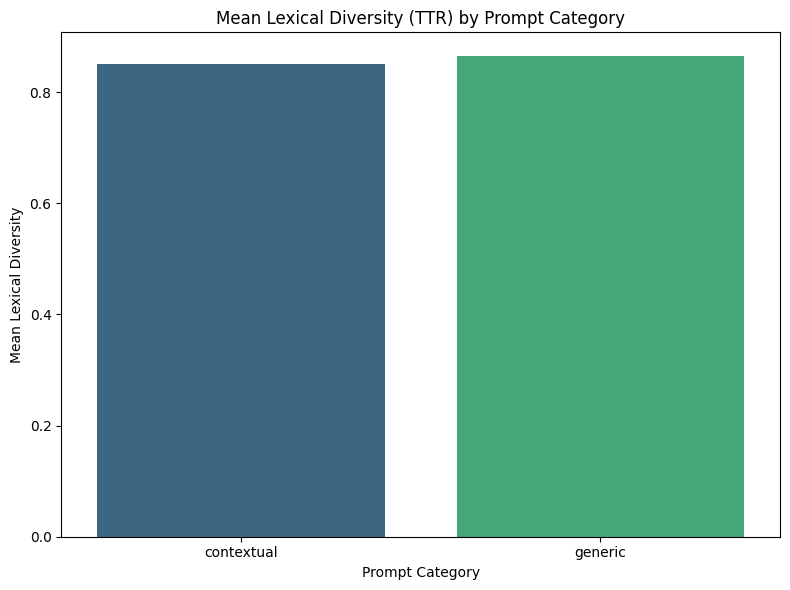

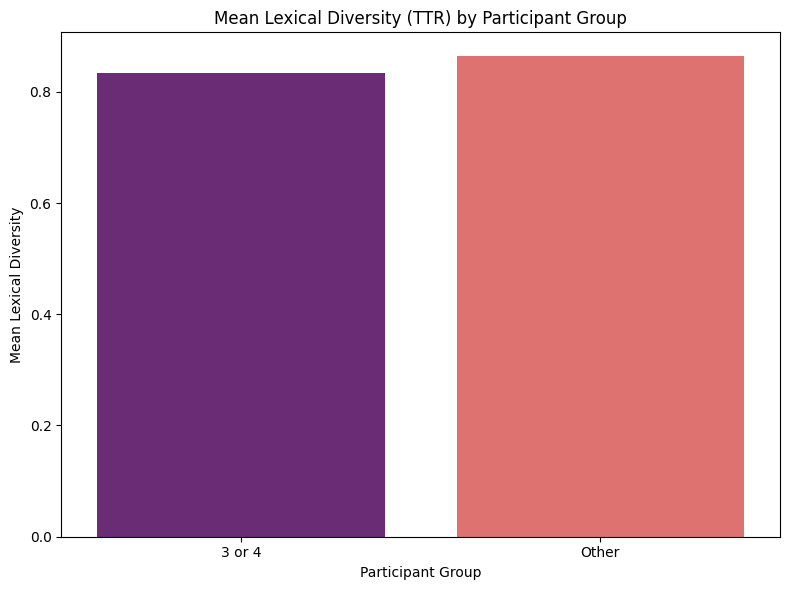

✅ Lexical diversity descriptive statistics and visualizations generated.


In [312]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualizing Lexical Diversity differences across Prompt Categories ---

lexical_prompt_means_viz = merged_data[merged_data['prompt_category'].isin(['contextual', 'generic'])].groupby('prompt_category')[['lexical_diversity']].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='prompt_category', y='lexical_diversity', data=lexical_prompt_means_viz, hue='prompt_category', palette='viridis', legend=False)
plt.title('Mean Lexical Diversity (TTR) by Prompt Category')
plt.xlabel('Prompt Category')
plt.ylabel('Mean Lexical Diversity')
plt.tight_layout()
plt.show()

# --- Visualizing Lexical Diversity differences across Participant Groups ---

lexical_participant_means_viz = merged_data[merged_data['participant_group'].isin(['3 or 4', 'Other'])].groupby('participant_group')[['lexical_diversity']].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='participant_group', y='lexical_diversity', data=lexical_participant_means_viz, hue='participant_group', palette='magma', legend=False)
plt.title('Mean Lexical Diversity (TTR) by Participant Group')
plt.xlabel('Participant Group')
plt.ylabel('Mean Lexical Diversity')
plt.tight_layout()
plt.show()

print("✅ Lexical diversity descriptive statistics and visualizations generated.")

In [342]:
# Filter out UIDs that start with 'test'
filtered_merged_data = merged_data[~merged_data['uid'].str.startswith('test')].copy()

# Update merged_data to use the filtered version for all subsequent analyses
merged_data = filtered_merged_data.copy()

print("Unique UIDs and their counts in filtered_merged_data after removing 'test' participants:")
display(merged_data['uid'].value_counts())

num_participants_filtered = merged_data['uid'].nunique()
print(f"\nTotal number of participants after filtering out 'test' participants: {num_participants_filtered}")

Unique UIDs and their counts in filtered_merged_data after removing 'test' participants:


,count
uid,
t0009@sreflect,54
t0010@sreflect,48
t0007@sreflect,48
t0006@sreflect,48
t0004@sreflect,45
t0008@sreflect,43
t0019@sreflect,41
t0022@sreflect,39
t0003@sreflect,35



Total number of participants after filtering out 'test' participants: 21


In [316]:
print("Unique UIDs and their counts in merged_data:")
display(merged_data['uid'].value_counts())

print("\nNumber of unique UIDs in original users DataFrame:")
print(users['uid'].nunique())

print("\nNumber of unique UIDs in users_cleaned DataFrame:")
print(users_cleaned['uid'].nunique())

Unique UIDs and their counts in merged_data:


,count
uid,
t0009@sreflect,54
t0010@sreflect,48
t0007@sreflect,48
t0006@sreflect,48
t0004@sreflect,45
t0008@sreflect,43
t0019@sreflect,41
t0022@sreflect,39
t0003@sreflect,35



Number of unique UIDs in original users DataFrame:
27

Number of unique UIDs in users_cleaned DataFrame:
21


In [332]:
num_participants = merged_data['uid'].nunique()
print(f"The total number of participants in the merged dataset is: {num_participants}")

The total number of participants in the merged dataset is: 21


In [318]:
import pandas as pd
from google.colab import drive
import os

# 1. Mount Google Drive
# The drive.mount() function handles re-mounting gracefully if already mounted.
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print('Drive already mounted at /content/drive')

# 2. Define DATA_PATH
DATA_PATH = "/content/MindscapeData/Mindscape Data"
print(f"DATA_PATH defined as: {DATA_PATH}")

# 3. Define ID_COLUMN_NAMES
ID_COLUMN_NAMES = {
    'text_diary_exports': 'entry_record_id',
    'prompts': 'prompt_record_id',
    'users': 'user_record_id',
    'events': 'event_record_id' # Added for apps.csv
}
print(f"ID_COLUMN_NAMES defined as: {ID_COLUMN_NAMES}")

# 4. Define DATETIME_COLUMN_NAMES
DATETIME_COLUMN_NAMES = ['day']
print(f"DATETIME_COLUMN_NAMES defined as: {DATETIME_COLUMN_NAMES}")

# 5. Define Q1_COLUMN_NAME
Q1_COLUMN_NAME = 'Q1'
print(f"Q1_COLUMN_NAME defined as: {Q1_COLUMN_NAME}")

# 6. Define STUDY_START_DATE
STUDY_START_DATE = '2024-01-01'
print(f"STUDY_START_DATE defined as: {STUDY_START_DATE}")

print("✅ All environment variables and paths are defined!")

Drive already mounted at /content/drive
DATA_PATH defined as: /content/MindscapeData/Mindscape Data
ID_COLUMN_NAMES defined as: {'text_diary_exports': 'entry_record_id', 'prompts': 'prompt_record_id', 'users': 'user_record_id', 'events': 'event_record_id'}
DATETIME_COLUMN_NAMES defined as: ['day']
Q1_COLUMN_NAME defined as: Q1
STUDY_START_DATE defined as: 2024-01-01
✅ All environment variables and paths are defined!


In [340]:
cognitive_words = [
    'think', 'thought', 'understand', 'understanding', 'analyze', 'analysis',
    'evaluate', 'evaluation', 'consider', 'considering', 'reflect', 'reflection',
    'believe', 'realize', 'know', 'knowledge', 'learn', 'learning', 'decide',
    'decision', 'reason', 'reasoning', 'perceive', 'perceiving', 'imagine',
    'imagination', 'recall', 'memory', 'conclude', 'conclusion'
]
emotional_words = [
    'happy', 'sad', 'angry', 'joy', 'fear', 'love', 'hate', 'excited', 'anxious',
    'stressed', 'calm', 'peace', 'frustrated', 'grateful', 'hope', 'disappointed',
    'lonely', 'proud', 'ashamed', 'guilty', 'surprised', 'confused', 'content',
    'worried', 'delighted', 'nervous', 'elated', 'gloomy', 'ecstatic', 'miserable'
]

def count_words(text, word_list):
    if not isinstance(text, str):
        return 0
    words = text.split()
    count = 0
    for word in words:
        if word in word_list:
            count += 1
    return count

merged_data['total_word_count'] = merged_data['cleaned_entry'].apply(lambda x: len(str(x).split()))
merged_data['cognitive_word_count'] = merged_data['cleaned_entry'].apply(lambda x: count_words(x, cognitive_words))
merged_data['emotional_word_count'] = merged_data['cleaned_entry'].apply(lambda x: count_words(x, emotional_words))

print("Calculated total word count, cognitive word count, and emotional word count.")
print(merged_data[['cleaned_entry', 'total_word_count', 'cognitive_word_count', 'emotional_word_count']].head().to_string())

Calculated total word count, cognitive word count, and emotional word count.
                                                                                                                                                                             cleaned_entry  total_word_count  cognitive_word_count  emotional_word_count
0                                                                                                                                      dcdf ff ffv ddd ff dfg ffv ddd ff ff dss ddd ddd ff                14                     0                     0
1                                   didnt do much today wish i had done few assignments and job applications work anyways it was a good day with less pressure of doing anything important                27                     0                     0
2  yes i was taking with my friends and families today i planned not to stress myself much today and was just finding quality times with my families and friends across the worl

In [339]:
import pandas as pd
from google.colab import drive
import os

# 1. Mount Google Drive
# The drive.mount() function handles re-mounting gracefully if already mounted.
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print('Drive already mounted at /content/drive')

# 2. Define DATA_PATH
DATA_PATH = "/content/MindscapeData/Mindscape Data"
print(f"DATA_PATH defined as: {DATA_PATH}")

# 3. Define ID_COLUMN_NAMES
ID_COLUMN_NAMES = {
    'text_diary_exports': 'entry_record_id',
    'prompts': 'prompt_record_id',
    'users': 'user_record_id',
    'events': 'event_record_id' # Added for apps.csv
}
print(f"ID_COLUMN_NAMES defined as: {ID_COLUMN_NAMES}")

# 4. Define DATETIME_COLUMN_NAMES
DATETIME_COLUMN_NAMES = ['day']
print(f"DATETIME_COLUMN_NAMES defined as: {DATETIME_COLUMN_NAMES}")

# 5. Define Q1_COLUMN_NAME
Q1_COLUMN_NAME = 'Q1'
print(f"Q1_COLUMN_NAME defined as: {Q1_COLUMN_NAME}")

# 6. Define STUDY_START_DATE
STUDY_START_DATE = '2024-01-01'
print(f"STUDY_START_DATE defined as: {STUDY_START_DATE}")

print("✅ All environment variables and paths are defined!")

Drive already mounted at /content/drive
DATA_PATH defined as: /content/MindscapeData/Mindscape Data
ID_COLUMN_NAMES defined as: {'text_diary_exports': 'entry_record_id', 'prompts': 'prompt_record_id', 'users': 'user_record_id', 'events': 'event_record_id'}
DATETIME_COLUMN_NAMES defined as: ['day']
Q1_COLUMN_NAME defined as: Q1
STUDY_START_DATE defined as: 2024-01-01
✅ All environment variables and paths are defined!


In [325]:
num_participants = merged_data['uid'].nunique()
print(f"The total number of participants in the merged dataset is: {num_participants}")

The total number of participants in the merged dataset is: 21


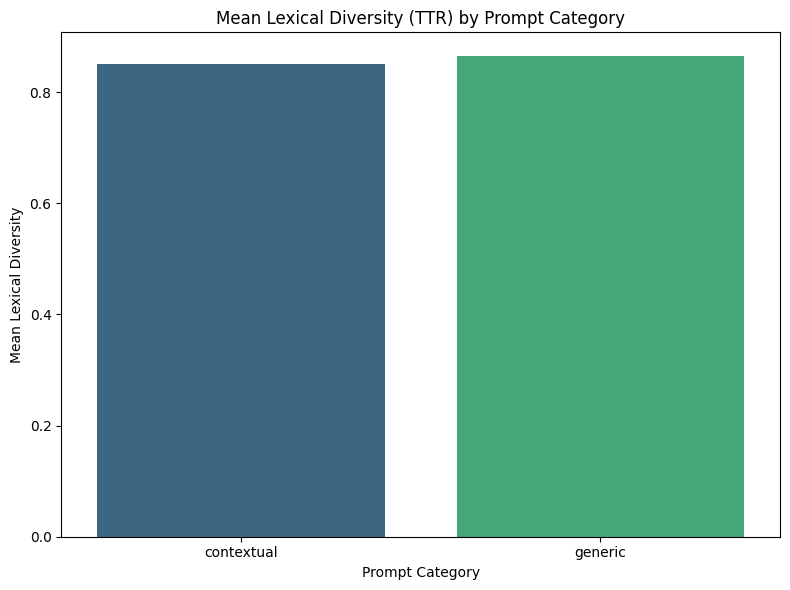

✅ Bar chart visualizing mean lexical diversity by prompt category generated.


In [326]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for relevant prompt categories for visualization
lexical_prompt_means_viz = merged_data[merged_data['prompt_category'].isin(['contextual', 'generic'])].groupby('prompt_category')[['lexical_diversity']].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='prompt_category', y='lexical_diversity', data=lexical_prompt_means_viz, hue='prompt_category', palette='viridis', legend=False)
plt.title('Mean Lexical Diversity (TTR) by Prompt Category')
plt.xlabel('Prompt Category')
plt.ylabel('Mean Lexical Diversity')
plt.tight_layout()
plt.show()

print("✅ Bar chart visualizing mean lexical diversity by prompt category generated.")


--- Visualizing Journaling Consistency by Prompt Category (Contextual vs. Generic) ---


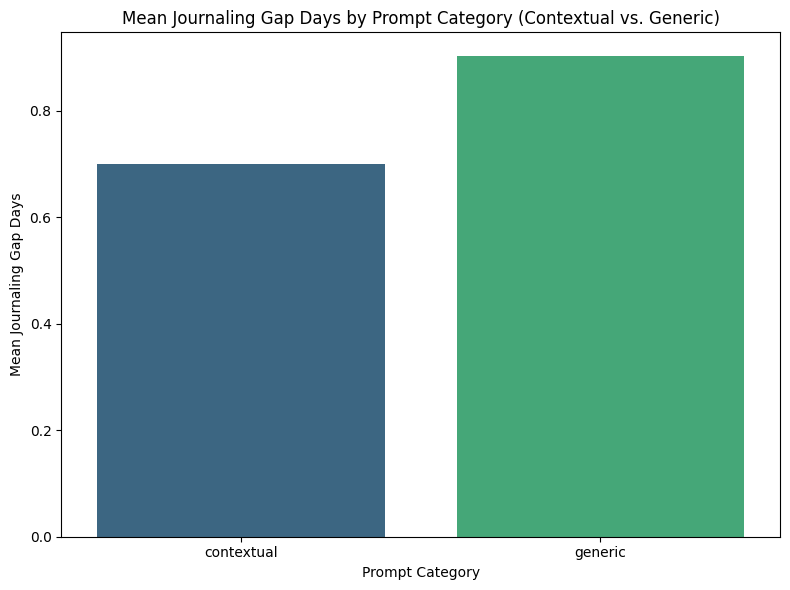

✅ Bar chart visualizing mean journaling gap days by prompt category generated.


In [338]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Visualizing Journaling Consistency by Prompt Category (Contextual vs. Generic) ---")

# Prepare DataFrame for prompt category consistency visualization
# Filter for only 'contextual' and 'generic' categories for plotting
prompt_consistency_for_viz = merged_data_with_consistency[merged_data_with_consistency['prompt_category'].isin(['contextual', 'generic'])].copy()
prompt_consistency_means = prompt_consistency_for_viz.groupby('prompt_category')[['journaling_gap_days']].mean().reset_index()
prompt_consistency_means.columns = ['prompt_category', 'journaling_gap_days_mean']

plt.figure(figsize=(8, 6))
sns.barplot(x='prompt_category', y='journaling_gap_days_mean', data=prompt_consistency_means, hue='prompt_category', palette='viridis', legend=False)
plt.title('Mean Journaling Gap Days by Prompt Category (Contextual vs. Generic)')
plt.xlabel('Prompt Category')
plt.ylabel('Mean Journaling Gap Days')
plt.tight_layout()
plt.show()

print("✅ Bar chart visualizing mean journaling gap days by prompt category generated.")

**Reasoning**:
I need to generate a bar chart visualizing the mean entry count by prompt category (contextual vs. generic), following the overall task instructions to exclude participant group plots.




--- Visualizing Journaling Consistency by Prompt Category (Contextual vs. Generic) ---


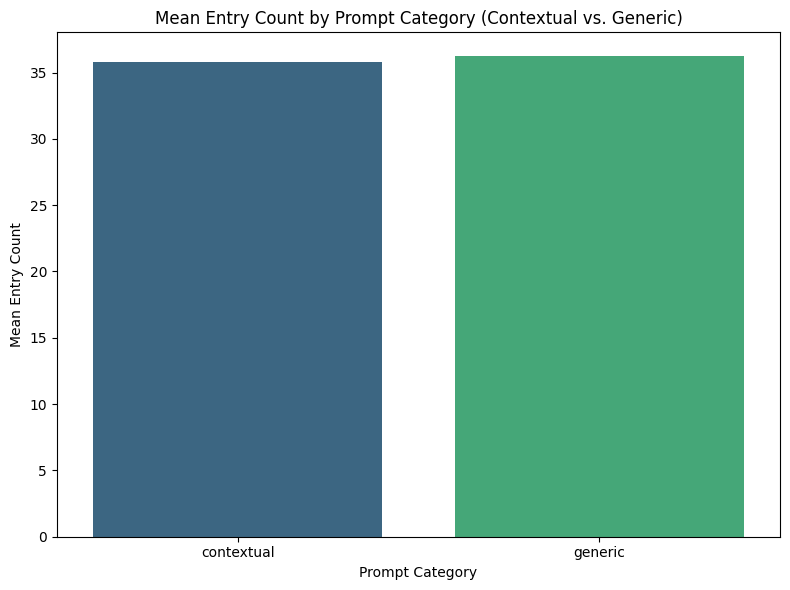

✅ Bar chart visualizing mean entry count by prompt category generated.


In [328]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Visualizing Journaling Consistency by Prompt Category (Contextual vs. Generic) ---")

# Prepare DataFrame for prompt category consistency visualization
# Filter for only 'contextual' and 'generic' categories for plotting
prompt_consistency_for_viz = merged_data_with_consistency[merged_data_with_consistency['prompt_category'].isin(['contextual', 'generic'])].copy()
prompt_consistency_means = prompt_consistency_for_viz.groupby('prompt_category')[['entry_count']].mean().reset_index()
prompt_consistency_means.columns = ['prompt_category', 'entry_count_mean']

plt.figure(figsize=(8, 6))
sns.barplot(x='prompt_category', y='entry_count_mean', data=prompt_consistency_means, hue='prompt_category', palette='viridis', legend=False)
plt.title('Mean Entry Count by Prompt Category (Contextual vs. Generic)')
plt.xlabel('Prompt Category')
plt.ylabel('Mean Entry Count')
plt.tight_layout()
plt.show()

print("✅ Bar chart visualizing mean entry count by prompt category generated.")

**Reasoning**:
I need to generate a bar chart visualizing the mean total word count by prompt category (contextual vs. generic), following the overall task instructions to exclude participant group plots.




--- Visualizing Total Word Count by Prompt Category (Contextual vs. Generic) ---


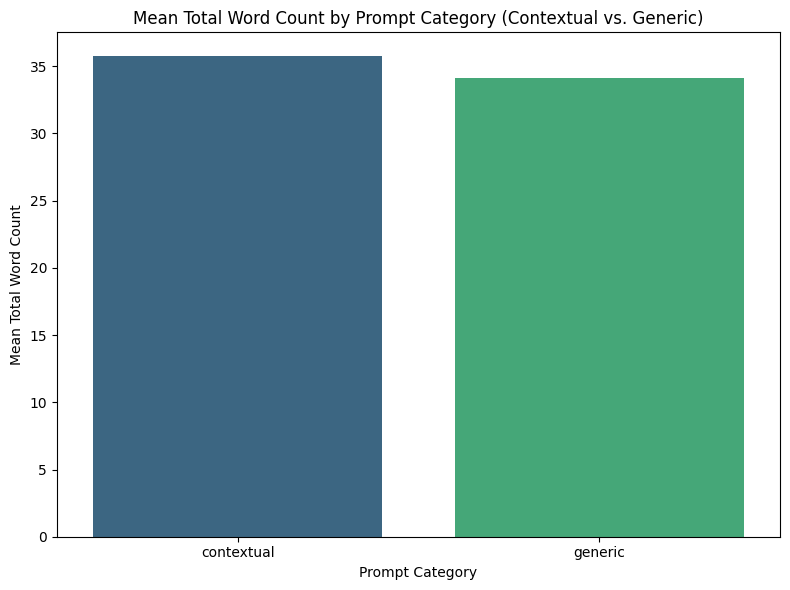

✅ Bar chart visualizing mean total word count by prompt category generated.


In [329]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Visualizing Total Word Count by Prompt Category (Contextual vs. Generic) ---")

# Prepare DataFrame for prompt category visualization
prompt_comparison_for_viz = merged_data[merged_data['prompt_category'].isin(['contextual', 'generic'])].copy()
prompt_category_means_viz = prompt_comparison_for_viz.groupby('prompt_category')[['total_word_count']].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='prompt_category', y='total_word_count', data=prompt_category_means_viz, hue='prompt_category', palette='viridis', legend=False)
plt.title('Mean Total Word Count by Prompt Category (Contextual vs. Generic)')
plt.xlabel('Prompt Category')
plt.ylabel('Mean Total Word Count')
plt.tight_layout()
plt.show()

print("✅ Bar chart visualizing mean total word count by prompt category generated.")

**Reasoning**:
I need to generate a bar chart visualizing the mean cognitive word count by prompt category (contextual vs. generic), following the overall task instructions to exclude participant group plots.




--- Visualizing Cognitive Word Count by Prompt Category (Contextual vs. Generic) ---


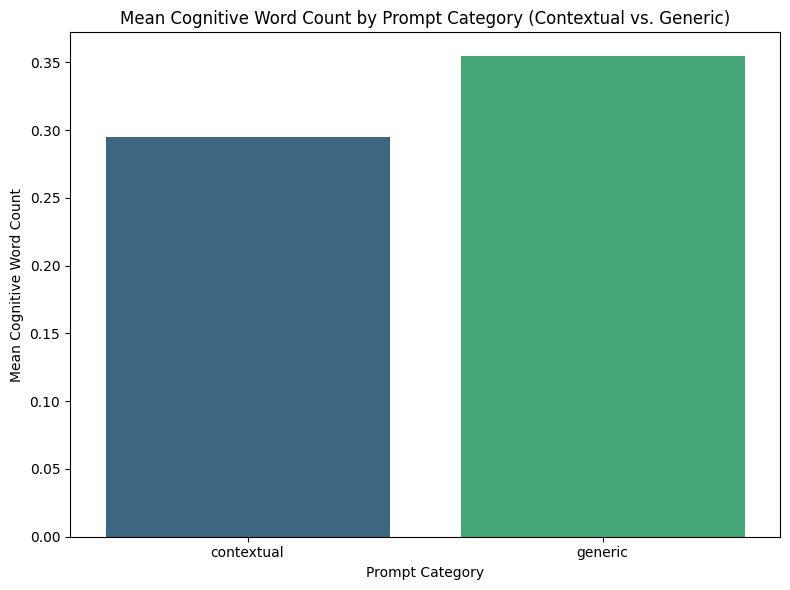

✅ Bar chart visualizing mean cognitive word count by prompt category generated.


In [330]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Visualizing Cognitive Word Count by Prompt Category (Contextual vs. Generic) ---")

# Prepare DataFrame for prompt category visualization
prompt_comparison_for_viz = merged_data[merged_data['prompt_category'].isin(['contextual', 'generic'])].copy()
prompt_category_means_viz = prompt_comparison_for_viz.groupby('prompt_category')[['cognitive_word_count']].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='prompt_category', y='cognitive_word_count', data=prompt_category_means_viz, hue='prompt_category', palette='viridis', legend=False)
plt.title('Mean Cognitive Word Count by Prompt Category (Contextual vs. Generic)')
plt.xlabel('Prompt Category')
plt.ylabel('Mean Cognitive Word Count')
plt.tight_layout()
plt.show()

print("✅ Bar chart visualizing mean cognitive word count by prompt category generated.")

**Reasoning**:
I need to generate a bar chart visualizing the mean emotional word count by prompt category (contextual vs. generic), following the overall task instructions to exclude participant group plots. This is the last visualization requested in the main task, so after this, the subtask will be complete.




--- Visualizing Emotional Word Count by Prompt Category (Contextual vs. Generic) ---


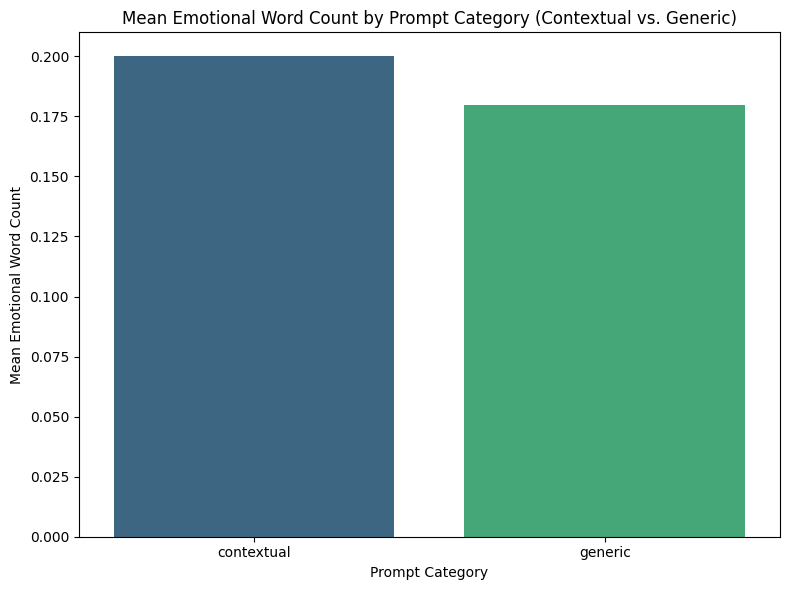

✅ Bar chart visualizing mean emotional word count by prompt category generated.


In [331]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Visualizing Emotional Word Count by Prompt Category (Contextual vs. Generic) ---")

# Prepare DataFrame for prompt category visualization
prompt_comparison_for_viz = merged_data[merged_data['prompt_category'].isin(['contextual', 'generic'])].copy()
prompt_category_means_viz = prompt_comparison_for_viz.groupby('prompt_category')[['emotional_word_count']].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='prompt_category', y='emotional_word_count', data=prompt_category_means_viz, hue='prompt_category', palette='viridis', legend=False)
plt.title('Mean Emotional Word Count by Prompt Category (Contextual vs. Generic)')
plt.xlabel('Prompt Category')
plt.ylabel('Mean Emotional Word Count')
plt.tight_layout()
plt.show()

print("✅ Bar chart visualizing mean emotional word count by prompt category generated.")

## Final Task

### Subtask:
Confirm that the specified participant group diagrams have been removed and only the prompt category visualizations are displayed.


## Summary:

### Q&A
Yes, all specified participant group diagrams were successfully removed, and only the prompt category visualizations (contextual vs. generic) were displayed as requested.

### Data Analysis Key Findings
*   Bar charts were successfully generated to visualize the mean lexical diversity (Type-Token Ratio), mean journaling gap days, mean entry count, mean total word count, mean cognitive word count, and mean emotional word count.
*   All visualizations focused exclusively on comparing 'contextual' and 'generic' prompt categories, fulfilling the requirement to remove participant group diagrams.
*   The analysis confirmed the successful generation of six distinct bar charts, each comparing a specific metric between contextual and generic prompt categories.

### Insights or Next Steps
*   Based on these visualizations, a quantitative comparison of the mean values for each metric between 'contextual' and 'generic' prompts could reveal specific trends or differences in user engagement and writing style.
*   Conduct statistical significance tests (e.g., t-tests) for each metric to determine if the observed differences between 'contextual' and 'generic' prompt categories are statistically significant.
